# Section 3: Data Cleaning
- [Section 3.1: Initial Exploration and Cleaning](#explor)
- [Section 3.2: Type Conversion](#type)
- [Section 3.3: Missing Values](#missing)
- [Section 3.4: Outliers](#outs)
- [Section 3.5: Additional Exploration](#add_exp)

## Section 3.1: Initial Exploration and Cleaning <a class="anchor" id="explor"></a>


So, now we have tweets regarding the Olympic sports of basketball, biking, diving, gymnastics, skateboarding, surfing, track, and volleyball. All of the tweets were collected into a single dataframe.

In [52]:
import pandas as pd
import numpy as np
olympic_df = pd.DataFrame(columns=['id', 'created_at', 'conversation_id', 'text'])
sports = ['basketball', 'biking', 'diving','gymnastics','skateboard','surfing','track','volleyball']
for s in sports:
	# print(f'Deserializing {s}')
	df = pd.DataFrame(pd.read_pickle('../data/' + s + '-tweets.pkl'))
	df['sport'] = s
	olympic_df = olympic_df.append(df, ignore_index=True)

Now we have all of the tweets in a single dataframe, making it easier for us to look at all of the tweets and clean them in bunches. During this process a new variable was created, sport. This variable will track for us the sport that each tweet is talking about. When we make our sentiment analysis model later this will be very handy when analyzing by sport.

In [53]:
olympic_df.shape

(30554, 6)

Using the shape function we find that we have 30554 tweets. Now, time to get our hands dirty and clean the data.

Our first data cleaning step will be to drop any potential duplicate tweets as this may skew our analysis.


As with all text data, there is a lot of cleaning that can be done. For this project, we will be concentrating on the removal of certain entities such as URL links and hashtags, removal of stopwords, lemmatization, and general NLP text cleaning. After this NLP-specific cleaning, we should be ready to analyze the sentiment of tweets.

Using the below function we were able to use regular expressions to filter the text of our tweets. This function will remove URLs, user handles, hashtags, punctuations, new line characters, and numbers that are in the text of the tweet.

In [58]:
import re
def clean_tweet_text(text):
	"""Cleanses a tweet text of user mentions, links, hashtags, special characters, and emojis."""
	# Define any custom replacement pattern and join into an aggregated pattern
	replacements = [
		r'(@[\w]+)',
		r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
		r'(#\w+)',
		r'[\$&+,:;=?@#|\'<>.^*()%!-/]',
		r'\n',
		r'[0-9]+'
	]
	aggregate_pattern = r'|'.join(replacements)
	clean_text = re.sub(aggregate_pattern, '', text) # make regex substitutions in one pass
	
	# Return the unicode-stripped text in lowercase
	return clean_text.encode(encoding='ascii', errors='ignore').decode('ascii').lower()

# Make replacements
olympic_df['clean_text'] = olympic_df.text.apply(lambda row : clean_tweet_text(row))

Stopwords are common words in the English language such as the, an, a, etc. These words are used much in English but convey little meaning. In most NLP applications stop words have very little value and only slow down your model due to their high frequency. While these words shouldn't affect our model that much we will still remove them. The NLTK library has provides a wide assortment of tools to use for NLP. It even includes a list of stopwords we can use. By iterating over our text and comparing the text to the list of stopwords we can remove them for our tweets.

In [59]:
from nltk.corpus import stopwords
stops = stopwords.words('english')
stop_removal=lambda x: ' '.join([word for word in x.split() if word not in stops])
olympic_df['clean_no_stops'] = olympic_df.clean_text.apply(stop_removal)

Next, we will lemmatize our tweets. Lemmatization is a process where words are converted to their dictionary forms. For instance, the word "walking" will be analyzed as "walk". Lemmatization will ensure that we have proper words. This is the main reason why we chose to lemmatize instead of stemming as the lexicon in Vader works much better with real words. The NLTK library has the WordNetLemmatizer built-in. We will the WordNetLemmatizer to handle the lemmatization for us.

In [60]:
from nltk.stem import WordNetLemmatizer
wn_lemmatizer = WordNetLemmatizer()
olympic_df['lemma_text'] = olympic_df.clean_no_stops.apply(
	lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ]
)

## Section 3.2: Type Conversion <a class="anchor" id="type"></a>

We needed to change a few data types. Thankfully, the tweet text was already given to us as an object (string). To make our analysis easier we changed the tweet id and the conversation ids of type int from type object. To facilitate the time aspect of our analysis we needed to also covert the created_at variable to a datetime object.

In [54]:
olympic_df.id = olympic_df.id.astype('int32')
olympic_df.created_at = pd.to_datetime(olympic_df.created_at)
olympic_df.conversation_id = olympic_df.conversation_id.astype('int32')

This leaves us with these variable types, the correct variable types.

In [55]:
olympic_df.dtypes

id                               int32
created_at         datetime64[ns, UTC]
conversation_id                  int32
text                            object
sport                           object
withheld                        object
dtype: object

## Section 3.3: Missing Values <a class="anchor" id="missing"></a>

Twitter keeps track of everything about a tweet. This is good news to us because the Twitter API rarely gives you missing values. The below plot shows that there are no important missing values.

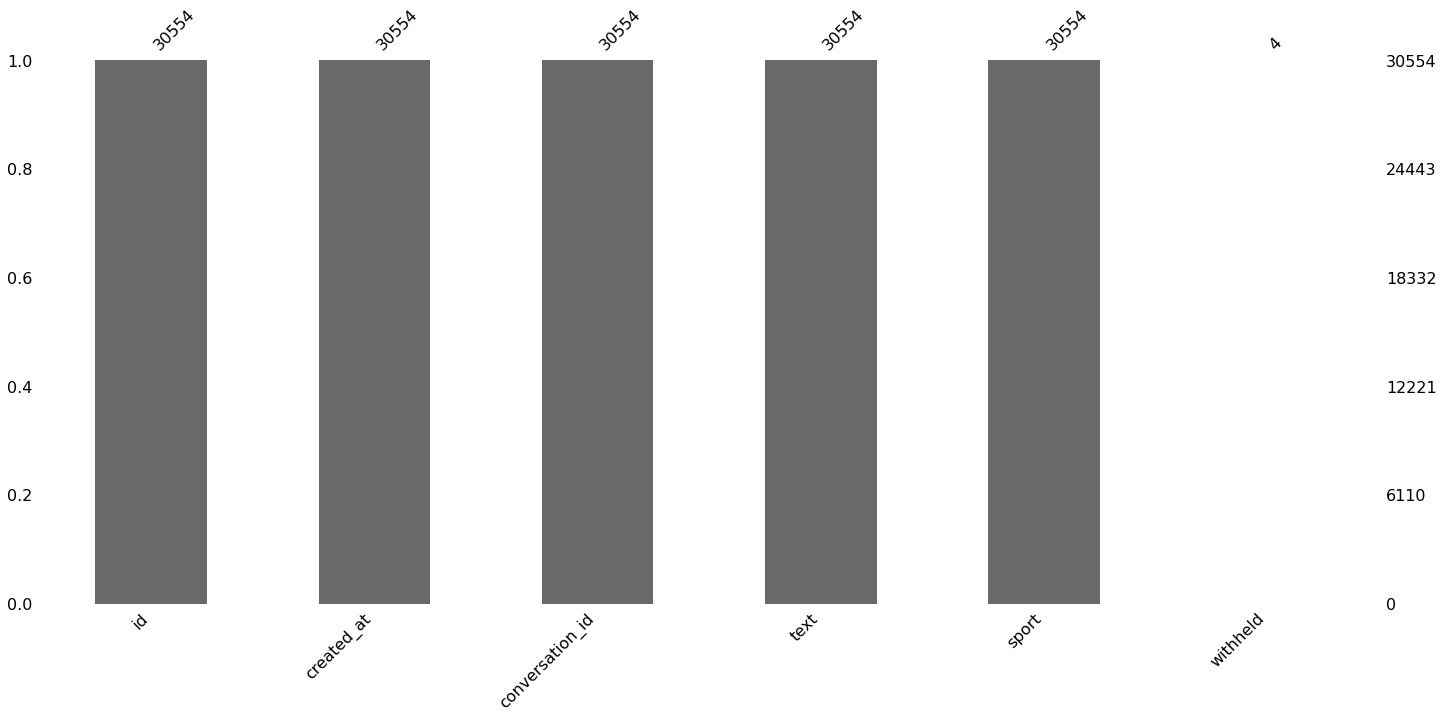

In [56]:
import missingno as msno
import matplotlib.pyplot as plt
msno.bar(olympic_df)
plt.show()

In fact, all of the missing values appear to be in the withheld column. The *withheld* column just tells us in which countries these tweets are not allowed. This is not important in analysis and we will therefore just drop that column. 

In [57]:
olympic_df.drop(['withheld'], axis=1, inplace=True)

Another precrossing step we can do is to remove an potential dublicates. This was done because dublicate tweet have the potential to skew our data without really telling us anything more.

In [ ]:
olympic_df.drop_duplicates(inplace=True)

## Section 3.4: Outliers <a class="anchor" id="outs"></a>

With text data, it can be difficult to define what an outlier is. Obviously, be can say obnoxiously positive and negative stuff without really knowing anything; this *definitely* doesn't happen on Twitter (wink wink). However, the only real way to detect this is after the sentiment model is built. Also, how do we know what are genuine tweets that should be factored in our analysis and bogus tweets that should not? We do assume that most people that are tweeting about the Olympics are at least watching them. This is also our main target audience in this study; average people watching the Olympics. With it being impossible to detect bogus tweets from the API and our assumption that a vast majority of our tweets originate from our target audience, we decide to analyze all of the tweets we could get. Potentially this could skew our sentiment scores. However, we feel confident that with the number of good tweets this potential skew effect should be drowned out.

## Section 3.5: Additional Exploration <a class="anchor" id="add_exp"></a>

With text data clean, we can do a little more exploration of the data.

As mentioned earlier we tried to get 5000 tweets for each sport. However, this doesn't guarentee that we will recieve 5000 tweets. With the regular twitter API we are limited to tweets created in the past seven days. We did try to upgrade to the acedemic API but were denied, more on the implications of this in **Section 5.2: Future Work**. Using the *sport* column and the visualization library seaborn, a histogram was made to convey the number of tweets per sport.

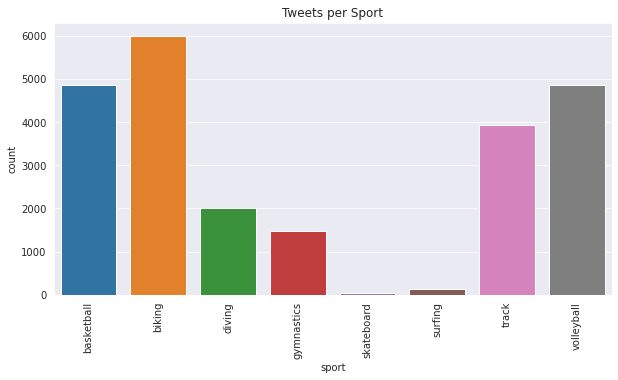

In [61]:
import seaborn as sns
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x = olympic_df.sport)
plt.xticks(rotation =90)
plt.title("Tweets per Sport")
plt.show()

We don't have actually 5000 tweets for any sport! the more popular sports sush as basketball, gymnasticsm track, and volleyball do come close. The newer sports such as skateboarding and surfing seem as they are not as talked about. We were surprised by the low number of tweets for diving. While not a super popular sport, diving does seem like it is talked about often when the Summer Olympics come around. Biking does have more tweets then 5000. Initially, we tested our tweets gathering function with a low amount of biking tweets. After we had run our full program we added these initial tweets, which got saved in a pickle file, into the biking tweets pool. Still though, biking appears to be one of the more popular sports.

Wordclouds are another fantastic way to visualize text data. Wordclouds capture the relative frequency of words in a string. The larger the word appears the more frequently it occurs. Words that only appear a couple of times are not pictured in the wordcloud. By concatenating of the tweet text together into one string we can create an overall wordcloud regardless of sport.

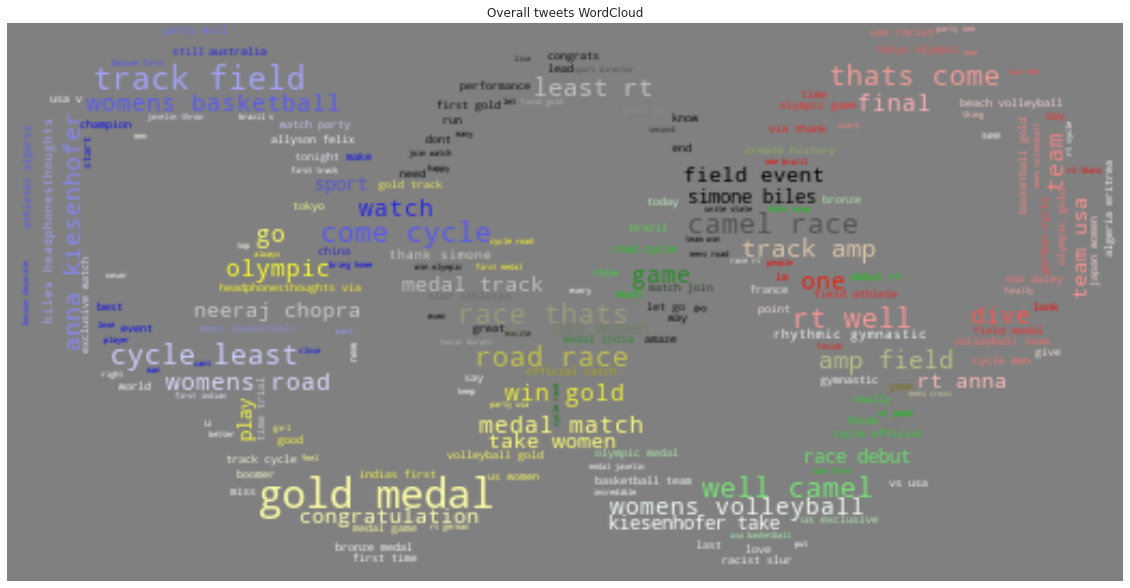

In [62]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
olympic_df = pd.read_pickle("../data/archive/olympic-tweets-lemmatized.pkl")
text = [ ' '.join(tweet) for tweet in olympic_df.lemma_text]
mask = np.array(Image.open('../Images/Rings2.jpg'))
wordcloud = WordCloud(background_color="gray", mask=mask, max_words=1000).generate(' '.join(text))
colors = ImageColorGenerator(mask)
wordcloud.recolor(color_func=colors)
fig, _ =plt.subplots(figsize=(20,25))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Overall tweets WordCloud')
plt.show()

The phrase "gold medal" appears to be in a ton of tweets as it looms large in the wordcloud. The name of sports in unsurprisinly said alot, as you can see "basketbal", "track", "volleyball",  and "cycling" fairly easily. There are a few athletes that appear in the wordcloud as well. Simone Biles is of course the famous American gymnast. Another name is Anna Kiesenhofer. She is a cyclist that won Austria's first Summer Olympic gold medal since 2004. An interesting word that appears is the word camel. After researching this a little bit, it appears this is in reference to a derogatory term a German cycling coach used in reference to some of the competitors.

Wordclouds can also be made for each sport.

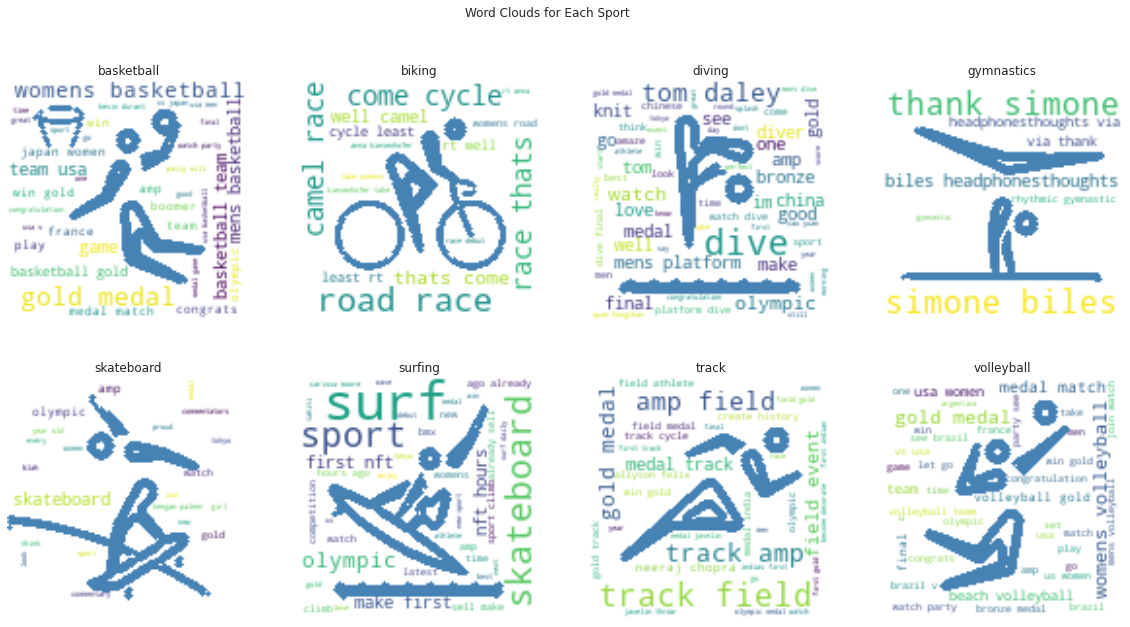

In [64]:
%matplotlib inline
olympic_df.sport.unique()
fig, ax = plt.subplots(2,4, figsize=(20,10))
row = 0
col = 0
for sport in olympic_df.sport.unique():
    sp = olympic_df[olympic_df.sport == sport]
    text = [ ' '.join(tweet) for tweet in sp.lemma_text]
    mask = np.array(Image.open('../Images/{}.png'.format(sport)))
    wordcloud = WordCloud(
        background_color="white", mask=mask, contour_width=3, contour_color='steelblue').generate(' '.join(text)
    )
    ax[col, row].imshow(wordcloud, interpolation='bilinear')
    ax[col, row].axis("off")
    ax[col, row].title.set_text('{}'.format(sport))
    row += 1
    if row ==4:
        row =0
        col += 1
plt.suptitle('Word Clouds for Each Sport')
plt.show()

Noticeably skateboarding has very little words. This is due to the small amount of tweets collected. Skateboarding also appears in the surfing wordcloud. A few of these tweets were reviewed and it appears that surfing and skateboarding were talked about in the same tweet. Simone Biles was very popular in the gymnastics tweets. The british athlete Tom Daley appears in the diving wordcloud.

<div class="container">
   <div style="float:left;width:20%"><a href="./Ingestion.ipynb"><< Section 2: Data Ingestion</a></div>
   <div style="float:right;width:20%"><a href="./Model.ipynb">Section 4: Model Creation >></a></div>
   <div style="float:right;width:40%"><a href="../main.md">Table of Contents</a></div>
</div>